# EEG Feature Extraction


# Importing all required libraries


In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import csv
import pickle
import os
import seaborn as sns
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
import scipy.io

import matplotlib.pyplot as plt
import io
import matplotlib.cm as cm
from collections import defaultdict
from scipy import signal

In [2]:
import os

# Understanding data

<br>We have sampling frequency = 128Hz
<br>1st 10 minutes of data(t=0 min to t=10 min) is for "focussed" state
<br>2nd 10 minutes of data(t=10 min to t=20 min) is for "unfocussed" state
<br>Remaining data(t=20 min to onwards) is for "Drowsed" state

<br>Therefore,
<br>"focused": row=$0$ to row=$128\times10\times60$
<br>"unfocused": row=$128\times10\times60$ to row=$128\times20\times60$
<br>"drowsed": row=$128\times20\times60$ to last row

In [3]:
data_root = '../input/eeg-data-for-mental-attention-state-detection/eeg data/EEG Data/'

In [4]:
files = os.listdir(data_root)

In [5]:
mat = scipy.io.loadmat(data_root + files[1])

In [6]:
mat['o']['sampFreq'][0][0][0][0]

128

In [7]:
data = mat['o']['data'][0, 0]
FS = mat['o']['sampFreq'][0][0][0][0]

data


array([[47.,  0.,  0., ...,  0.,  0.,  0.],
       [48.,  0.,  0., ...,  0.,  0.,  0.],
       [49.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [36.,  0.,  0., ...,  0.,  0.,  0.],
       [37.,  0.,  0., ...,  0.,  0.,  0.],
       [38.,  0.,  0., ...,  0.,  0.,  0.]])

4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'

In [8]:
channel_indices = np.array(range(3, 17))
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
channel_map = dict(zip(channel_names, channel_indices))

In [9]:
df = pd.DataFrame.from_dict(data)

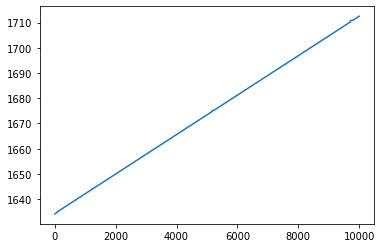

In [10]:

channel = data[:10000, 19]
plt.plot(channel)

In [11]:
data.shape

(363232, 25)

In [12]:
states = {
 'focused': data[:FS * 10 * 60, :],
  'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
  'drowsy': data[FS * 30 * 60:, :],
}

In [13]:
bands = {'alpha': (8, 13), 'delta': (0.5, 4), 'beta': (13, 30), 'gamma': (30, np.inf)}



In [14]:
def get_data(filename):
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = mat['o']['data'][0, 0]
    FS = mat['o']['sampFreq'][0][0][0][0]

    states = {
     'focused': data[:FS * 10 * 60, :],
      'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
      'drowsy': data[FS * 30 * 60:, :],
    }
    return states

In [15]:
def get_powers(channel, FS=128):
    channel = channel - channel.mean()
    freq, psd = signal.periodogram(channel, fs=FS, nfft=256)

    powers = {}
    for band_name, band_limits in bands.items():
        low, high = band_limits
        powers[band_name] = psd[(freq >= low) & (freq < high)].mean()
    return powers

In [16]:
subjects = [5, 10, 20, 25, 33]

In [17]:

rows_list = []
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            powers = get_powers(eeg[:, ch_idx])
            powers['state'] = state
            powers['channel'] = ch_name
            powers['subject'] = f"subject_{subject_idx}"
            rows_list.append(powers)

In [18]:
df = pd.DataFrame.from_dict(rows_list)

In [19]:
df.head()

,alpha,delta,beta,gamma,state,channel,subject
0,0.109188,0.121637,0.179848,0.041091,focused,AF3,subject_5
1,0.083879,0.078891,0.074366,0.038357,unfocused,AF3,subject_5
2,0.035458,0.109983,0.039020,0.016242,drowsy,AF3,subject_5
3,1.927219,36.255531,0.892434,0.213194,focused,F7,subject_5
4,1.758539,36.506171,0.590528,0.163570,unfocused,F7,subject_5


In [20]:
df.describe()

,alpha,delta,beta,gamma
count,210.000000,210.000000,210.000000,210.000000
mean,3.893512,74.534303,0.639226,0.115020
std,9.307750,262.369517,0.860707,0.182259
min,0.000000,0.000000,0.000000,0.000000
25%,0.072074,0.129839,0.058051,0.026212
50%,1.274391,5.959509,0.356482,0.076365
75%,3.644501,48.477687,0.956902,0.150123
max,71.833644,2933.818633,7.587283,2.111892


In [21]:
df.to_csv("eeg_powers.csv")

In [22]:
samp_freq = 128 
total_subjects = 5
subject_map = {}
for s in range(1, total_subjects+1):
    a =  int(7*(s-1)) + 3
    if s!=5: 
        b = a + 5
    else:
        b = a + 4 #subject5 has 4 trials
    subject_map[s] = [i for i in range(a, b)]
print(subject_map)

{1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}
